
### 1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>. You have to use data.csv file for this assignment
### 2. Code the model to classify data like below image. You can use any number of units in your Dense layers.

<img src='https://i.imgur.com/33ptOFy.png'>



In [109]:
import tensorflow as tf
import pandas as pd
import numpy as np


from keras.callbacks import Callback,ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense

import datetime
import os

In [103]:
data = pd.read_csv('/content/data.csv')

In [104]:
y = data['label']

In [105]:
data = data.drop(['label'], axis=1)

In [106]:
X = data

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=46)

In [108]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18000, 2)
(18000,)
(2000, 2)
(2000,)


In [ ]:
'''Y_train = tf.keras.utils.to_categorical(y_train, 10) 
Y_test = tf.keras.utils.to_categorical(y_test, 10)'''

# <font color='red'> <b>3. Writing Callbacks </b> </font>
## You have to implement the following callbacks
-  Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.Do not use tf.keras.metrics for calculating AUC and F1 score.

- Save your model at every epoch if your validation accuracy is improved from previous epoch. 

- You have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
- If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

- You have to stop the training if your validation accuracy is not increased in last 2 epochs.

- Use tensorboard for every model and analyse your scalar plots and histograms. (you need to upload the screenshots and write the observations for each model for evaluation)



In [212]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
# Monitor MicroF1 and AUC Score
def get_auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)


In [213]:
class f1Call(tf.keras.callbacks.Callback):
    def __init__(self,validation_data):
      self.x_test = validation_data[0]
      self.y_test= validation_data[1]

    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'f1_micro': []}

    def on_epoch_end(self, epoch, logs={}):
        y_pred= self.model.predict(self.x_test)
        y_label_pred=np.argmax(y_pred,axis=1)
        
        #we can also calcualte predefined metrics such as precison, recall, etc. using callbacks 
        f1_micro = f1_score(y_test, y_label_pred, average='micro')
        self.history['f1_micro'].append(f1_micro)
        print(' f1_micro:', f1_micro)

f1_micro_score = f1Call(validation_data=[X_test,y_test])

In [ ]:
# some code refrences:
# https://www.analyticsvidhya.com/blog/2021/08/quick-start-with-tensorflow-callbacks/#h2_7

In [214]:
# Save your model at every epoch if your validation accuracy is improved from previous epoch.

"""
# Save model callback
tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)


filePath = "models/Model1_weights.{epoch:02d}.hdf5"
model_checkpoint_callback = tf.keras.callbacksModelCheckpoint(
    filepath=filePath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max')
"""

# file path, it saves the model in the 'model_save' folder and we are naming model with epoch number 
# and val acc to differtiate with other models
# you have to create model_save folder before running the code.
filepath = "/content/model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')

In [215]:
# Condition 1
# If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the learning rate by 10%.
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [216]:
# Condition 2
# For every 3rd epoch, decay your learning rate by 5%.
def schedule(epoch,lr):
    if epoch % 3 == 0:
        lr = lr - (lr*.05)
        return lr
    return lr

# Decrease lr by 5% for every 3rd epoch
LrScheduler = tf.keras.callbacks.LearningRateScheduler(schedule,verbose=1)

In [217]:
# If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training.
# terminate training if loss is 'NaN'

class TerminateNaN(tf.keras.callbacks.Callback):
        
    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print("Invalid loss and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

        model_weights = self.model.get_weights()
        if model_weights is not None:
            if np.any([np.any(np.isnan(x)) for x in model_weights]):
                print("Invalid weight and terminated at epoch {}".format(epoch))
                self.model.stop_training = True

nan_callback = TerminateNaN()

# TerminateNaN = tf.keras.callbacks.TerminateOnNaN()

In [218]:
# You have to stop the training if your validation accuracy is not increased in last 2 epochs.
from keras.callbacks import EarlyStopping
stop_here_please = EarlyStopping(patience=2)

In [219]:
# Use tensorboard for every model and analyse your scalar plots and histograms.
# (you need to upload the screenshots and write the observations for each model for evaluation)
# TensorBoard
log_dir="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [220]:
# Use tensorboard for every model and analyse your scalar plots and histograms.
# (you need to upload the screenshots and write the observations for each model for evaluation)

In [221]:
#!pip install -q tf-nightly-2.0-preview
# if you want to use the tf2.0 please uncomment the above line
# Load the TensorBoard notebook extension

# there are other ways of doing this: https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/ you can try this way also
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [222]:
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [223]:
# here we are creating a list with all the callbacks we want
callback_list = [f1_micro_score, checkpoint, LrScheduler, stop_here_please, ReduceLROnPlateau, nan_callback, tensorboard_callback]

In [224]:
# Define model
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(512, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='tanh', input_shape=(input_shape,)))
model.add(Dense(256, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='tanh'))
model.add(Dense(128, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='tanh'))
model.add(Dense(64, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='tanh'))
model.add(Dense(32, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [225]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
               loss='binary_crossentropy',
               metrics=[get_auc, 'accuracy']
              )

In [226]:
model.fit(X_train, y_train,
          epochs=5,
          validation_data=(X_test,y_test),
          callbacks=callback_list
           )


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/5
560/563 [============================>.] - ETA: 0s - loss: 0.6982 - get_auc: 0.4996 - accuracy: 0.5014 f1_micro: 0.4915

Epoch 1: saving model to /content/model_save/weights-01-0.4890.hdf5
563/563 [==============================] - 4s 6ms/step - loss: 0.6983 - get_auc: 0.4991 - accuracy: 0.5012 - val_loss: 0.7034 - val_get_auc: 0.4889 - val_accuracy: 0.4890 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009499999694526196.
Epoch 2/5
559/563 [============================>.] - ETA: 0s - loss: 0.6993 - get_auc: 0.4954 - accuracy: 0.4984 f1_micro: 0.4915

Epoch 2: saving model to /content/model_save/weights-02-0.4890.hdf5
563/563 [==============================] - 3s 6ms/step - loss: 0.6992 - get_auc: 0.4953 - accuracy: 0.4990 - val_loss: 0.7036 - val_get_auc: 0.4889 - val_accuracy: 0.4890 - lr: 0.0095

Epoch 3: LearningRateScheduler setting learning rate to 0.00949999969452619

In [227]:
%tensorboard --logdir logs/fits

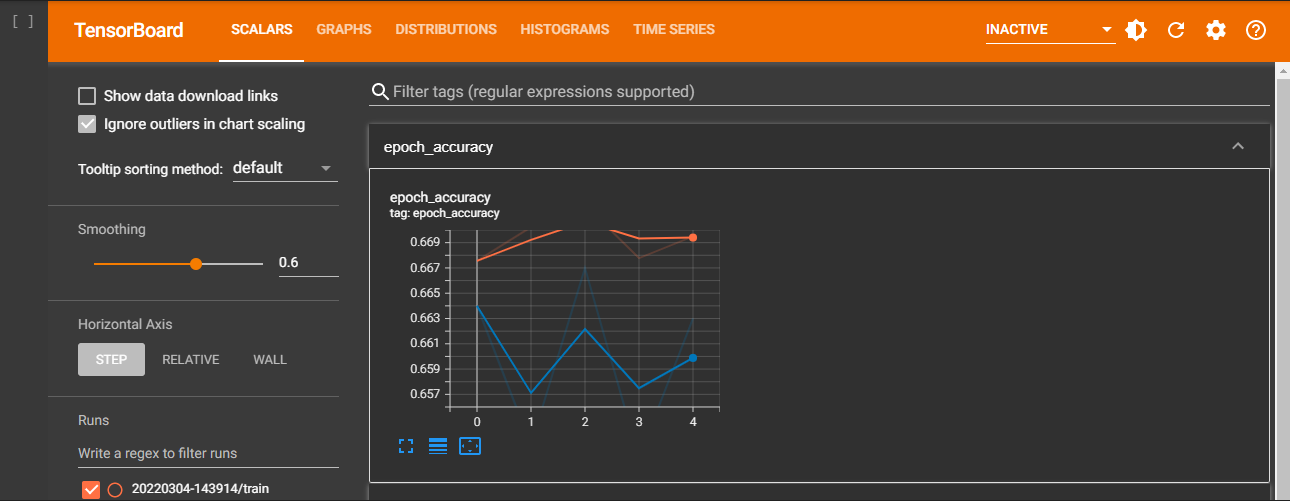

<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [228]:
# Define model
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(512, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='relu', input_shape=(input_shape,)))
model.add(Dense(256, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='relu'))
model.add(Dense(128, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='relu'))
model.add(Dense(64, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='relu'))
model.add(Dense(32, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [229]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
               loss='binary_crossentropy',
               metrics=[get_auc, 'accuracy'])

In [230]:
model.fit(X_train, y_train,
          epochs=5,
          validation_data=(X_test,y_test),
          callbacks = callback_list
           )


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/5
556/563 [============================>.] - ETA: 0s - loss: 19911.9180 - get_auc: 0.4999 - accuracy: 0.5049 f1_micro: 0.4915

Epoch 1: saving model to /content/model_save/weights-01-0.5085.hdf5
563/563 [==============================] - 5s 6ms/step - loss: 19681.8340 - get_auc: 0.4999 - accuracy: 0.5047 - val_loss: 0.6931 - val_get_auc: 0.5000 - val_accuracy: 0.5085 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009499999694526196.
Epoch 2/5
556/563 [============================>.] - ETA: 0s - loss: 0.6934 - get_auc: 0.5000 - accuracy: 0.4990 f1_micro: 0.4915

Epoch 2: saving model to /content/model_save/weights-02-0.4915.hdf5
563/563 [==============================] - 3s 6ms/step - loss: 0.6933 - get_auc: 0.5000 - accuracy: 0.4987 - val_loss: 0.6932 - val_get_auc: 0.5000 - val_accuracy: 0.4915 - lr: 0.0095

Epoch 3: LearningRateScheduler setting learning rate to 0.009499999

In [231]:
tensorboard --logdir logs/fits

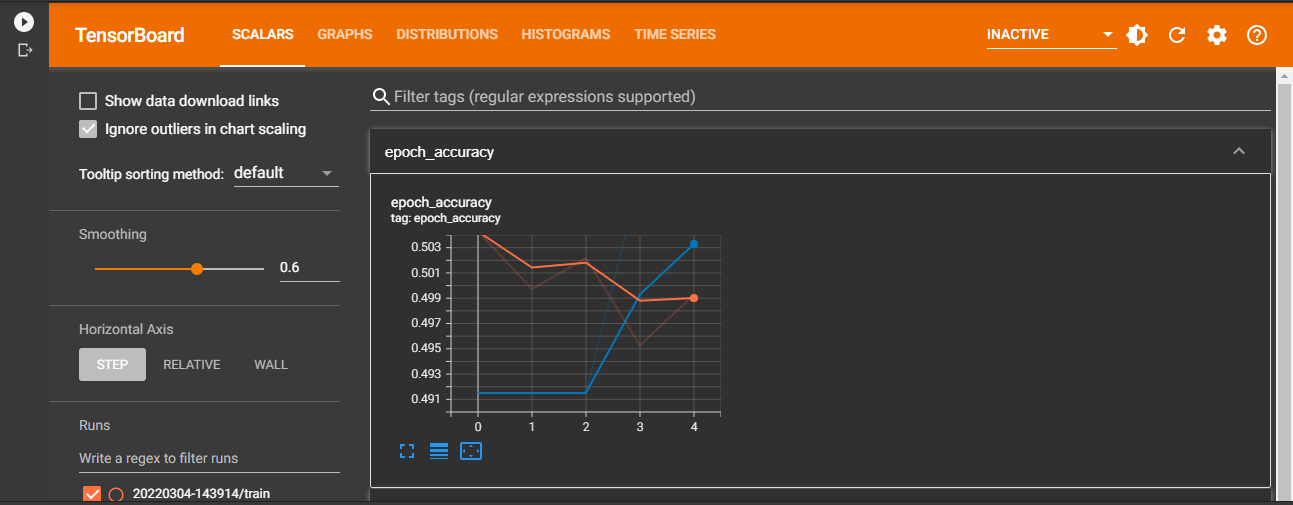

<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>

In [232]:
# Define model
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(512, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu', input_shape=(input_shape,)))
model.add(Dense(256, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(128, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(64, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(32, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [233]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
               loss='binary_crossentropy',
               metrics=[get_auc, 'accuracy'])

In [234]:
model.fit(X_train, y_train,
          epochs=5,
          validation_data=(X_test,y_test),
          callbacks = callback_list
           )


Epoch 1: LearningRateScheduler setting learning rate to 0.009499999787658453.
Epoch 1/5
553/563 [============================>.] - ETA: 0s - loss: 0.6561 - get_auc: 0.6883 - accuracy: 0.6139 f1_micro: 0.4915

Epoch 1: saving model to /content/model_save/weights-01-0.6465.hdf5
563/563 [==============================] - 4s 6ms/step - loss: 0.6553 - get_auc: 0.6898 - accuracy: 0.6143 - val_loss: 0.6225 - val_get_auc: 0.7255 - val_accuracy: 0.6465 - lr: 0.0095

Epoch 2: LearningRateScheduler setting learning rate to 0.009499999694526196.
Epoch 2/5
556/563 [============================>.] - ETA: 0s - loss: 0.6240 - get_auc: 0.7251 - accuracy: 0.6463 f1_micro: 0.4915

Epoch 2: saving model to /content/model_save/weights-02-0.6520.hdf5
563/563 [==============================] - 3s 6ms/step - loss: 0.6242 - get_auc: 0.7245 - accuracy: 0.6461 - val_loss: 0.6151 - val_get_auc: 0.7185 - val_accuracy: 0.6520 - lr: 0.0095

Epoch 3: LearningRateScheduler setting learning rate to 0.00949999969452619

In [235]:
%tensorboard --logdir logs/fits

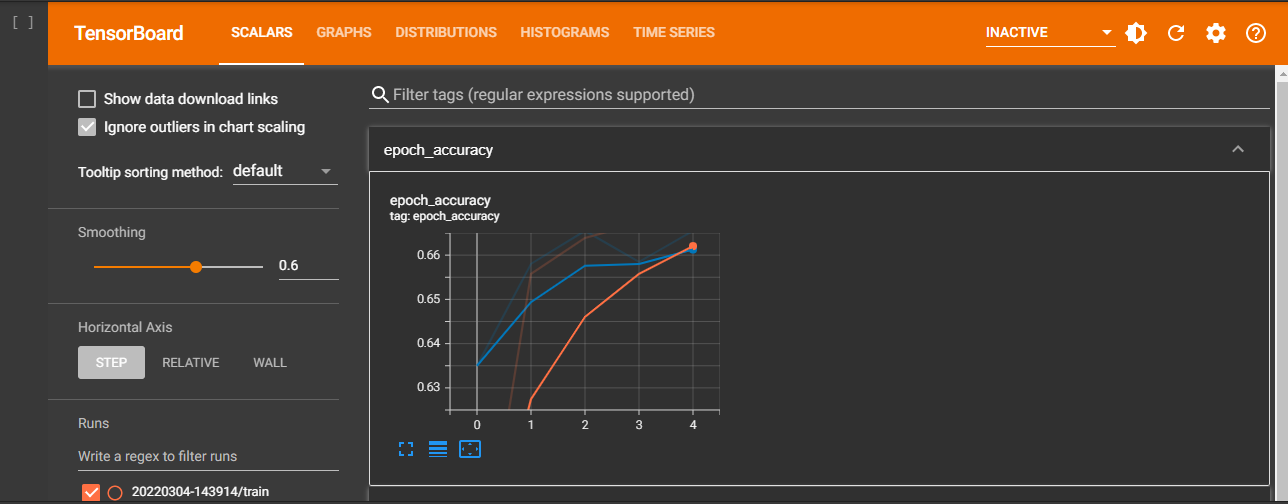




<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [236]:
# Define model
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(512, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu', input_shape=(input_shape,)))
model.add(Dense(256, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(128, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(64, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(32, kernel_initializer = tf.keras.initializers.he_uniform(seed=None), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [237]:
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=[get_auc, 'accuracy'])

In [238]:
model.fit(X_train, y_train,
          epochs=10,
          validation_data=(X_test,y_test),
          callbacks = callback_list
           )


Epoch 1: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/10
557/563 [============================>.] - ETA: 0s - loss: 0.6711 - get_auc: 0.6478 - accuracy: 0.5843 f1_micro: 0.4915

Epoch 1: saving model to /content/model_save/weights-01-0.6365.hdf5
563/563 [==============================] - 4s 7ms/step - loss: 0.6708 - get_auc: 0.6486 - accuracy: 0.5848 - val_loss: 0.6388 - val_get_auc: 0.7118 - val_accuracy: 0.6365 - lr: 9.5000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/10
563/563 [==============================] - ETA: 0s - loss: 0.6195 - get_auc: 0.7293 - accuracy: 0.6560 f1_micro: 0.4915

Epoch 2: saving model to /content/model_save/weights-02-0.6710.hdf5
563/563 [==============================] - 4s 6ms/step - loss: 0.6195 - get_auc: 0.7293 - accuracy: 0.6560 - val_loss: 0.6044 - val_get_auc: 0.7373 - val_accuracy: 0.6710 - lr: 9.5000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00095

In [239]:
%tensorboard --logdir logs/fits

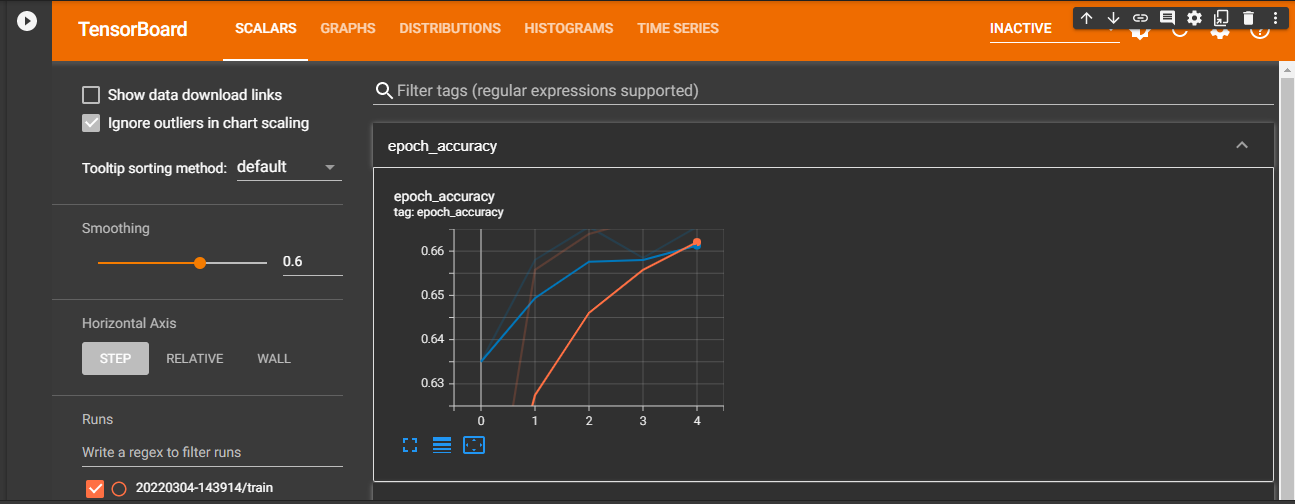

<pre>
Observations:
1 - 'relu' activation performs better than tanh activation for hidden layers.
2 - 'he' distribution as initilizer works better than the 'RandomUniform(0,1)'